# Introduction
We are now ready to get to work. The following Notebook is all about preliminary data exploration. Starting with our improved *Metadata_Extended.csv*, we seek to answer some basic questions about the dataset we were given and pave the way for our qiime pipeline.
Some questions we want to answer with this Notebook are:

- did the two sequencing techniques generate different number of mags per sample?
- are all samples sequenced by both techniques?
- what is the genome size distribution of our datasets?
- compare n50 and L50 for two different techniques

other interesting questions are:  
- nation of origin distribution of samples?
- what foods types are sampled in what proportion?





## Setup

In [1]:
#set up environment
import os
import pandas as pd
import qiime2 as q2
from qiime2 import Visualization
%matplotlib inline
import matplotlib.pyplot as plt

# create directories for the notebook. DO NOT change
raw_data = 'data/raw'
metadata_dir = 'data/processed/metadata'
visualization

# fetches useful files for the current notebook. All files will be saved in $data_dir
#!wget 'https://polybox.ethz.ch/index.php/s/nMa2WaWEDft3kMr/download' -O data/Download.zip
#!unzip -o data/Download.zip -d data
#!rm data/Download.zip

In [2]:
%%bash -s "$raw_data" "$metadata_dir"
mkdir -p "$1"
mkdir -p "$2"

## importing Metadata_Expanded

In [3]:
metadata = pd.read_csv(f'{metadata_dir}/Metadata_Extended.tsv', sep='\t')
metadata.head(3) # Let's take a quick peek

,sample-id,mag-id,sample,samp_country,category,fermented_food_type
0,PB_B039_Aa_Gp_La,6de933c6-afeb-4e58-b764-f8ba5fc0d366,B039_Aa_Gp_La,Benin,fermented fish,Lanhouin
1,PB_B039_Aa_Gp_La,8d28fd5f-5f2c-4508-9764-1c20ebffa8df,B039_Aa_Gp_La,Benin,fermented fish,Lanhouin
2,PB_B039_Aa_Gp_La,c0a09ab4-2630-4493-a84e-67f8b764d4d9,B039_Aa_Gp_La,Benin,fermented fish,Lanhouin


# Exploration
## Question 1: Mags per sample compared
It is important to compare sequencing techniques retrieved MAGs on a per-sample basis as they may represent differences in read depth and quality, which is one of the questions we aim to answer for our project. Visualizing how the MAGs are distributed is also useful to acknowledje possible batch effect due to the different sample size down the line.

In [4]:
# Group metadata by sample and sample-id, optaining a frequency per sample per technique
counts = metadata.groupby(['sample', 'sample-id']).size().reset_index(name='count')
counts.head(5)

,sample,sample-id,count
0,36fe4,PB_36fe4,8
1,3ee22,PB_3ee22,4
2,9b8b5,PB_9b8b5,6
3,A001,IL_A001,29
4,A001,PB_A001,112


In [5]:
# IL subset
IL = counts[counts['sample-id'].str.startswith('IL_')]

# PB subset
PB = counts[counts['sample-id'].str.startswith('PB_')]


A barplot showing the frequencies of both techniques per sample is a good way to visualize our dataset

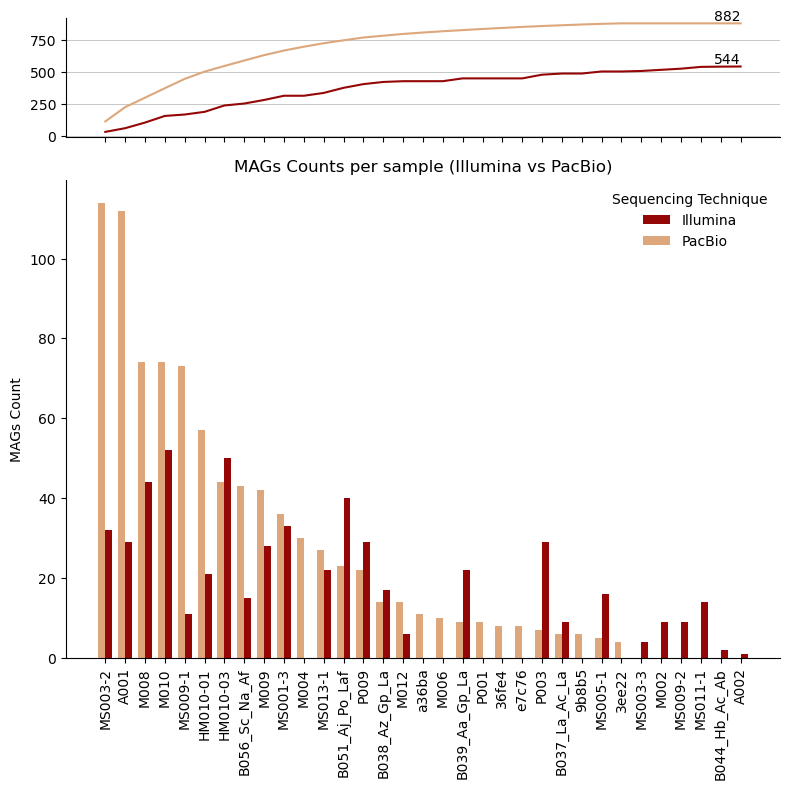

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Merge IL and PB counts
merged = IL[['sample', 'count']].rename(columns={'count':'IL_count'}).merge(
    PB[['sample', 'count']].rename(columns={'count':'PB_count'}),
    on='sample', how='outer'
).fillna(0)

# Sort by PB_count descending
merged = merged.sort_values('PB_count', ascending=False)

samples = merged['sample']
x = np.arange(len(samples))
width = 0.35

# Plot barplots
fig, (cum, ax) = plt.subplots(2,1, figsize=(8,8), sharex=True, gridspec_kw={'height_ratios': [1, 4]})
ax.bar(x + width/2, merged['IL_count'], width, label='Illumina', color = '#950606')
ax.bar(x - width/2, merged['PB_count'], width, label='PacBio', color = '#DDA77B')

#Plot cumulative line plot
cumulative_IL = merged['IL_count'].cumsum()
cumulative_PB = merged['PB_count'].cumsum()
cum.plot(x, cumulative_IL, linewidth=1.5, color = '#950606')
cum.plot(x, cumulative_PB, linewidth=1.5, color = '#DDA77B')
last_x = x[-1]

#Plot cumulative sum
# IL label
cum.text(
    last_x,
    cumulative_IL.iloc[-1],
    str(int(cumulative_IL.iloc[-1])),
    va='bottom',
    ha='right'
)
# PB label
cum.text(
    last_x,
    cumulative_PB.iloc[-1],
    str(int(cumulative_PB.iloc[-1])),
    va='bottom',
    ha='right'
)


# hide borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
cum.spines['top'].set_visible(False)
cum.spines['right'].set_visible(False)

#Axis lables
ax.set_xticks(x)
ax.set_xticklabels(samples, rotation=90)
ax.set_ylabel('MAGs Count')
ax.set_title('MAGs Counts per sample (Illumina vs PacBio)')
ax.legend(title='Sequencing Technique', frameon=False)
cum.grid(axis='y', linestyle='-', linewidth=0.5)

##show plot
plt.tight_layout()
plt.show()


## Question 2: Are all samples sequenced by both techniques?
The next step is to divide an count for each sample how many *sample-id* start with IL or PB prefix and summarize the results in a graphic visualization

In [7]:
# Number of unique samples
num_unique_samples = counts['sample'].nunique()

# Count samples that have both IL and PB entries
# First, create flags for IL and PB
flags = counts.assign(
    is_IL = counts['sample-id'].str.startswith('IL_'),
    is_PB = counts['sample-id'].str.startswith('PB_')
)

# Aggregate by sample to see if both exist
agg = flags.groupby('sample')[['is_IL','is_PB']].any()

num_samples_both = (agg['is_IL'] & agg['is_PB']).sum()

num_unique_samples, num_samples_both


(33, 19)

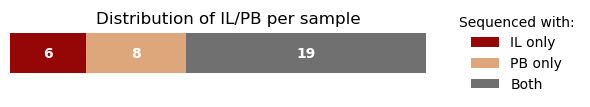

In [8]:
import matplotlib.pyplot as plt

# Categories
agg['category'] = 'Neither'
agg.loc[agg['is_IL'] & ~agg['is_PB'], 'category'] = 'IL only'
agg.loc[~agg['is_IL'] & agg['is_PB'], 'category'] = 'PB only'
agg.loc[agg['is_IL'] & agg['is_PB'], 'category'] = 'Both'

counts_per_category = agg['category'].value_counts()
categories = ['IL only', 'PB only', 'Both']  # control order
counts_ordered = counts_per_category.reindex(categories, fill_value=0)

# Plot
fig, ax = plt.subplots(figsize=(6,1))
bottom = 0
colors = ['#950606','#DDA77B','#707070']

for cat, color in zip(categories, colors):
    value = counts_ordered[cat]
    ax.barh(0, value, left=bottom, label=cat, color=color)
    # Add count label inside the bar
    if value > 0:
        ax.text(bottom + value/2, 0, str(value), ha='center', va='center', color='white', fontweight='bold')
    bottom += value

# hide borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.set_yticks([])  # remove y-axis
ax.set_xticks([])  # remove x-axis
ax.set_title('Distribution of IL/PB per sample')
ax.legend(title='Sequenced with:', frameon=False, loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()


## Genome Size Distribution

## N50 and L50
for the N50 and L50 

## Geographic Diversity
Understanding the Geographical context where the samples have been collected can be useful to interpret results. For example temperature and humidity combinations or geographical vicinity could be associated with composition features. 

Since a clear disparity already is visible in the MAGs per sample analysis, it would be interesting to see if the disparity is associated with the geographical location. To visualize this a MAGs/sample ration is plotted for each country

In [9]:
metadata.head(3)

,sample-id,mag-id,sample,samp_country,category,fermented_food_type
0,PB_B039_Aa_Gp_La,6de933c6-afeb-4e58-b764-f8ba5fc0d366,B039_Aa_Gp_La,Benin,fermented fish,Lanhouin
1,PB_B039_Aa_Gp_La,8d28fd5f-5f2c-4508-9764-1c20ebffa8df,B039_Aa_Gp_La,Benin,fermented fish,Lanhouin
2,PB_B039_Aa_Gp_La,c0a09ab4-2630-4493-a84e-67f8b764d4d9,B039_Aa_Gp_La,Benin,fermented fish,Lanhouin


since 

In [10]:
countries = metadata['samp_country'].unique()
countries_MAG_count = metadata.groupby('samp_country').size().reset_index(name='count')
countries_sample_count = metadata.groupby('samp_country')['sample'].nunique().reset_index(name='num_samples')

In [11]:
# Output is quiet because long and boring, if you wish to see the output remove the -q argument.
!pip install -q geopandas
!pip install -q adjustText

  Using cached geopandas-1.1.1-py3-none-any.whl.metadata (2.3 kB)
  Using cached pyogrio-0.12.1-cp310-cp310-manylinux_2_28_x86_64.whl.metadata (5.9 kB)
  Using cached pyproj-3.7.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (31 kB)
  Using cached shapely-2.1.2-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (6.8 kB)
Using cached geopandas-1.1.1-py3-none-any.whl (338 kB)
Using cached pyogrio-0.12.1-cp310-cp310-manylinux_2_28_x86_64.whl (32.4 MB)
Using cached pyproj-3.7.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.3 MB)
Using cached shapely-2.1.2-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (3.1 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [geopandas]/4 [geopandas]
  Using cached adjustText-1.3.0-py3-none-any.whl.metadata (3.1 kB)
Using cached adjustText-1.3.0-py3-none-any.whl (13 kB)


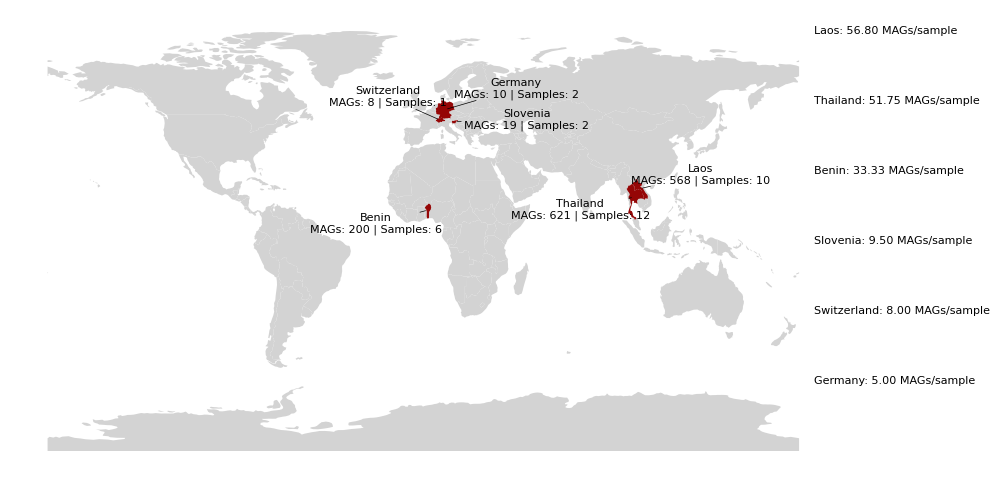

In [32]:
import geopandas as gpd
import matplotlib.pyplot as plt
from adjustText import adjust_text

#load map file
world = gpd.read_file('./additional_data/ne_110m_admin_0_countries.shp')

# Add countries to the highlight list to be colored afterward
world['highlight'] = world['NAME'].isin(countries)

# Add MAG counts
world = world.merge(
    countries_MAG_count.rename(columns={'count': 'mag_count'}),
    left_on='NAME', right_on='samp_country', how='left'
)

# Add sample counts
world = world.merge(
    countries_sample_count.rename(columns={'num_samples': 'sample_count'}),
    left_on='NAME', right_on='samp_country', how='left'
)

# Replace NaNs
world[['mag_count', 'sample_count']] = world[['mag_count', 'sample_count']].fillna(0)

# Compute MAGs per sample ratio
world['mag_per_sample'] = world.apply(
    lambda row: row['mag_count'] / row['sample_count'] if row['sample_count'] > 0 else 0,
    axis=1
)

#plot setup
fig, ax = plt.subplots(figsize=(14,6))

# Base map
world.plot(ax=ax, color='lightgray')

# Highlighted countries
world[world['highlight']].plot(ax=ax, color='#950606')

# Labels on countries
texts = []
for idx, row in world[world['highlight']].iterrows():
    label = f"{row['NAME']}\nMAGs: {int(row['mag_count'])} | Samples: {int(row['sample_count'])}"
    texts.append(
        ax.text(
            row.geometry.centroid.x,
            row.geometry.centroid.y,
            label,
            ha='center', va='center',
            fontsize=8
        )
    )

adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle='-', lw=0.5))

# MAGs per sample on the right side
right_x = world.geometry.total_bounds[2] + (world.geometry.total_bounds[2] - world.geometry.total_bounds[0])*0.02
highlighted_countries = world[world['highlight']].sort_values('mag_per_sample', ascending=False)

for i, row in enumerate(highlighted_countries.itertuples()):
    ax.text(
        right_x,
        world.geometry.total_bounds[3] - i*(world.geometry.total_bounds[3]-world.geometry.total_bounds[1])/len(highlighted_countries),
        f"{row.NAME}: {row.mag_per_sample:.2f} MAGs/sample",
        ha='left',
        va='center',
        fontsize=8,
        color='black'
    )

ax.set_axis_off()
plt.show()


This map shows the geographic distribution of MAGs and samples across countries. The dataset is geographically and quantitatively biased, which limits its usefulness for studying global fermentation microbiomes. Any interpretation must consider these limitations and ideally include more samples from underrepresented regions. Lower MAG counts in Europe could be influenced by more hygienic or controlled fermentation.

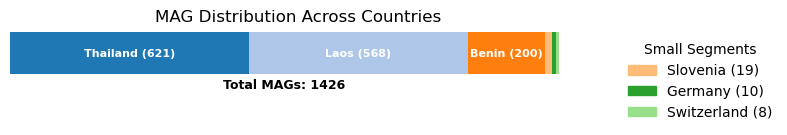

In [37]:
import matplotlib.pyplot as plt

df = countries_MAG_count.copy()
df = df.sort_values('count', ascending=False)

fig, ax = plt.subplots(figsize=(8, 1.2))

left = 0
colors = plt.cm.tab20(range(len(df)))   # distinct colors for countries

# store small segments for legend
small_segments = []

for (country, count), color in zip(df[['samp_country','count']].values, colors):
    ax.barh(
        0,
        count,
        left=left,
        color=color,
        edgecolor='none'
    )

    if count > df['count'].sum() * 0.03:
        # label inside large segments
        ax.text(
            left + count/2,
            0,
            f"{country} ({int(count)})",
            ha='center',
            va='center',
            fontsize=8,
            color='white',
            fontweight='bold'
        )
    else:
        # store small segments for legend
        small_segments.append((country, color))
    
    left += count
    
# Add total MAGs below the bar
total_mags = df['count'].sum()
ax.text(
    0.5 * left,      # middle of the total bar
    -0.6,            # below the bar
    f"Total MAGs: {int(total_mags)}",
    ha='center',
    va='center',
    fontsize=9,
    fontweight='bold'
)

# Clean plot
ax.set_yticks([])
ax.set_xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Add legend for small segments
if small_segments:
    handles = [plt.Rectangle((0,0),1,1, color=color) for country, color in small_segments]
    labels = [f"{country} ({int(df.loc[df['samp_country']==country,'count'].values[0])})" 
              for country, color in small_segments]
    ax.legend(handles, labels, title="Small Segments", bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)

ax.set_title("MAG Distribution Across Countries")
plt.tight_layout()
plt.show()


This plot represents the total number of metagenome-assembled genomes (MAGs) collected per country. It is clear that more than 80% of MAGs are from south-east asia, while less than 3% from Europe. The skewed MAG distribution can introduce bias, reduce representativeness, and affect downstream analyses, so it’s important to acknowledge it and, if possible, account for it (e.g., subsampling, weighting, or explicitly limiting conclusions to the sampled regions).

## Food-Type Diversity
Understanding the Type of food where the samples have been collected can be useful to interprete results. Different Food types likely have different composition that is beneficial for their preservation. This difference likely 

Since a clear disparity already is visible in the MAGs per sample analysis, it would be interesting to see if the disparity is associated with the food type. To visualize this a MAGs/sample ration is plotted for each food type same as the geographical analysis. 

In [38]:
metadata.head(3)

,sample-id,mag-id,sample,samp_country,category,fermented_food_type
0,PB_B039_Aa_Gp_La,6de933c6-afeb-4e58-b764-f8ba5fc0d366,B039_Aa_Gp_La,Benin,fermented fish,Lanhouin
1,PB_B039_Aa_Gp_La,8d28fd5f-5f2c-4508-9764-1c20ebffa8df,B039_Aa_Gp_La,Benin,fermented fish,Lanhouin
2,PB_B039_Aa_Gp_La,c0a09ab4-2630-4493-a84e-67f8b764d4d9,B039_Aa_Gp_La,Benin,fermented fish,Lanhouin


In [40]:
foodtype_MAG_count = metadata.groupby('category').size().reset_index(name='count')
countries_sample_count = metadata.groupby('category')['sample'].nunique().reset_index(name='num_samples')

/tmp/ipykernel_114/356276979.py:48: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  labels = [f"{food} ({int(df.loc[df['category']==food,'count'])})" for (food, color) in small_segments]


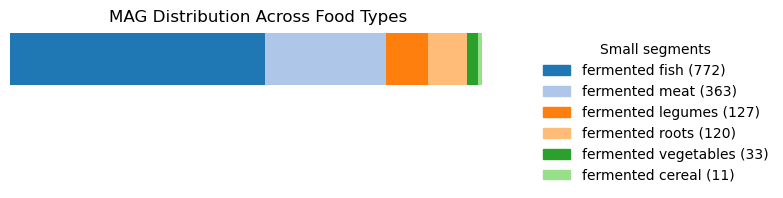

In [58]:
import matplotlib.pyplot as plt

df = foodtype_MAG_count.copy()
df = df.sort_values('count', ascending=False)

fig, ax = plt.subplots(figsize=(8, 1.5))

left = 0
colors = plt.cm.tab20(range(len(df)))
small_segments = []

for (food, count), color in zip(df[['category','count']].values, colors):
    ax.barh(
        0,
        count,
        left=left,
        color=color,
        edgecolor='none'
    )

    # label only if large enough
    if count > df['count'].sum() * 1:
        ax.text(
            left + count/2,
            0,
            f"{food} ({int(count)})",
            ha='center', va='center',
            fontsize=8,
            color='white',
            fontweight='bold'
        )
    else:
        small_segments.append((food, color))

    left += count

# clean up axes
ax.set_yticks([])
ax.set_xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# legend for small segments
if small_segments:
    handles = [plt.Rectangle((0,0),1,1, color=color) for (food, color) in small_segments]
    labels = [f"{food} ({int(df.loc[df['category']==food,'count'])})" for (food, color) in small_segments]
    ax.legend(handles, labels, title="Small segments", frameon=False,
              bbox_to_anchor=(1.05, 1), loc='upper left')

ax.set_title("MAG Distribution Across Food Types")
plt.tight_layout()
plt.show()


/tmp/ipykernel_114/4214394760.py:45: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  labels = [f"{food} ({int(df.loc[df['category']==food,'num_samples'])})"


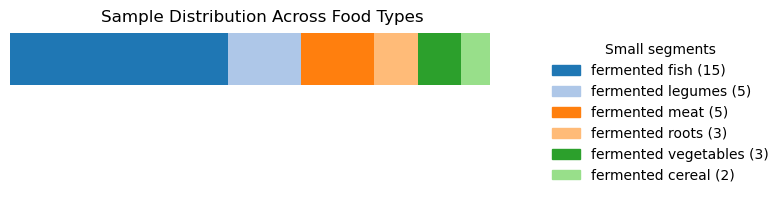

In [57]:
df = countries_sample_count.copy()
df = df.sort_values('num_samples', ascending=False)

fig, ax = plt.subplots(figsize=(8, 1.5))

left = 0
colors = plt.cm.tab20(range(len(df)))
small_segments = []

for (food, count), color in zip(df[['category','num_samples']].values, colors):
    ax.barh(
        0,
        count,
        left=left,
        color=color,
        edgecolor='none'
    )

    if count > df['num_samples'].sum() * 1:
        ax.text(
            left + count/2,
            0,
            f"{food} ({int(count)})",
            ha='center', va='center',
            fontsize=8,
            color='white',
            fontweight='bold'
        )
    else:
        small_segments.append((food, color))

    left += count

# clean axes
ax.set_yticks([])
ax.set_xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# legend
if small_segments:
    handles = [plt.Rectangle((0,0),1,1, color=color) for (food, color) in small_segments]
    labels = [f"{food} ({int(df.loc[df['category']==food,'num_samples'])})"
              for (food, color) in small_segments]
    ax.legend(handles, labels, title="Small segments", frameon=False,
              bbox_to_anchor=(1.05, 1), loc='upper left')

ax.set_title("Sample Distribution Across Food Types")
plt.tight_layout()
plt.show()


In [ ]:
import Bio
from Bio import SeqIO
import numpy as np

def calculate_gc_content(sequence):
    g = sequence.count('G')
    c = sequence.count('C')
    gc_content = (g + c) / len(sequence) * 100 if len(sequence) > 0 else 0
    return gc_content

def analyze_gc_content(fasta_file):
    gc_contents = []
    with open(fasta_file, 'r') as file:
        sequence = ""
        for line in file:
            line = line.strip()
            if line.startswith(">"):  # Header line (ignore it)
                if sequence:  # If there was a previous sequence, process it
                    gc_contents.append(calculate_gc_content(sequence))
                sequence = ""  # Reset sequence for the next record
            else:
                sequence += line  # Append sequence data
        if sequence: 
            gc_contents.append(calculate_gc_content(sequence))
    return gc_contents

# Function that walk through directories and process FASTA files
def process_directory(base_directory):
    all_gc_contents = []  # List to store all GC content values across all files
    for root, dirs, files in os.walk(base_directory):
        for file in files:
            if file.endswith(".fasta") or file.endswith(".fa"):
                fasta_file_path = os.path.join(root, file)
                gc_contents = analyze_gc_content(fasta_file_path)
                all_gc_contents.extend(gc_contents)  # Add the GC content from this file to the list
    return all_gc_contents


illumina_folder = 'data/Illumina_MAGs'
pacbio_folder = 'data/PacBio_MAGs'


illumina_gc = process_directory(illumina_folder)
pacbio_gc = process_directory(pacbio_folder)


def calculate_average_gc(gc_contents):
    return sum(gc_contents) / len(gc_contents) if gc_contents else 0


print(f"Average GC content for Illumina: {calculate_average_gc(illumina_gc):.2f}%")
print(f"Average GC content for PacBio: {calculate_average_gc(pacbio_gc):.2f}%")


**Both technologies recovered genomes with very similar base compositions.**

#### Calculating N50 and L50

In [ ]:
'''# Function to calculate N50 and L50
def calculate_n50_l50(contig_lengths):
    """Calculate the N50 and L50 of the contig lengths."""
    contig_lengths.sort(reverse=True)  # Sort contig lengths in descending order
    total_length = sum(contig_lengths)
    half_total_length = total_length / 2

    cumulative_length = 0
    n50 = 0
    l50 = 0
    for length in contig_lengths:
        cumulative_length += length
        l50 += 1
        if cumulative_length >= half_total_length and n50 == 0:
            n50 = length
    
    return n50, l50

# Function to get the lengths of sequences from a FASTA file
def get_contig_lengths(fasta_file):
    """Reads a FASTA file and returns a list of contig lengths."""
    contig_lengths = []
    with open(fasta_file, 'r') as file:
        sequence = ""
        for line in file:
            line = line.strip()
            if line.startswith(">"):  # Header line (ignore it)
                if sequence:  # If there was a previous sequence, process it
                    contig_lengths.append(len(sequence))
                sequence = ""  # Reset sequence for the next record
            else:
                sequence += line  # Appends sequence data
        if sequence:  # Process the last sequence
            contig_lengths.append(len(sequence))
    return contig_lengths

# Function that walk through directories and process FASTA files
def process_directory(base_directory):
    n50_results = {}

    for root, dirs, files in os.walk(base_directory):
        for file in files:
            if file.endswith(".fasta") or file.endswith(".fa"):
                fasta_file_path = os.path.join(root, file)
                
                # Get contig lengths from the file
                contig_lengths = get_contig_lengths(fasta_file_path)
                
                # If there are valid contigs, calculates N50 and L50
                if contig_lengths:
                    n50, l50 = calculate_n50_l50(contig_lengths)
                    n50_results[fasta_file_path] = (n50, l50)

    return n50_results

illumina_folder = 'data/Illumina_MAGs'
pacbio_folder = 'data/PacBio_MAGs'

# Process the directories and calculate N50 and L50
illumina_n50 = process_directory(illumina_folder)
pacbio_n50 = process_directory(pacbio_folder)

print("Illumina N50 and L50:")
for file, (n50, l50) in illumina_n50.items():
    print(f"{file}: N50 = {n50}, L50 = {l50}")

print("\nPacBio N50 and L50:")
for file, (n50, l50) in pacbio_n50.items():
    print(f"{file}: N50 = {n50}, L50 = {l50}")'''

In [ ]:
# Function to calculate N50 and L50
def calculate_n50_l50(contig_lengths):
    """Calculate the N50 and L50 of the contig lengths."""
    contig_lengths.sort(reverse=True)  # Sort contig lengths in descending order
    total_length = sum(contig_lengths)
    half_total_length = total_length / 2

    cumulative_length = 0
    n50 = 0
    l50 = 0
    for length in contig_lengths:
        cumulative_length += length
        l50 += 1
        if cumulative_length >= half_total_length and n50 == 0:
            n50 = length
    
    return n50, l50

# Function to get the lengths of sequences from a FASTA file
def get_contig_lengths(fasta_file):
    """Reads a FASTA file and returns a list of contig lengths."""
    contig_lengths = []
    with open(fasta_file, 'r') as file:
        sequence = ""
        for line in file:
            line = line.strip()
            if line.startswith(">"):  # Header line (ignore it)
                if sequence:  # If there was a previous sequence, process it
                    contig_lengths.append(len(sequence))
                sequence = ""  # Reset sequence for the next record
            else:
                sequence += line  # Append sequence data
        if sequence:  # Process the last sequence
            contig_lengths.append(len(sequence))
    return contig_lengths

# Function that walk through directories and process FASTA files
def process_directory(base_directory):
    all_contig_lengths = []

    for root, dirs, files in os.walk(base_directory):
        for file in files:
            if file.endswith(".fasta") or file.endswith(".fa"):
                fasta_file_path = os.path.join(root, file)
                
                # Getting contig lengths from the file
                contig_lengths = get_contig_lengths(fasta_file_path)
                
                # Adding contig lengths to the overall list
                if contig_lengths:
                    all_contig_lengths.extend(contig_lengths)

    return all_contig_lengths

illumina_folder = 'data/Illumina_MAGs'
pacbio_folder = 'data/PacBio_MAGs'

# Processing the directories and getting all contig lengths
illumina_contig_lengths = process_directory(illumina_folder)
pacbio_contig_lengths = process_directory(pacbio_folder)

# Calculating N50 and L50 for Illumina
if illumina_contig_lengths:
    illumina_n50, illumina_l50 = calculate_n50_l50(illumina_contig_lengths)
else:
    illumina_n50, illumina_l50 = 0, 0

# Calculating N50 and L50 for PacBio
if pacbio_contig_lengths:
    pacbio_n50, pacbio_l50 = calculate_n50_l50(pacbio_contig_lengths)
else:
    pacbio_n50, pacbio_l50 = 0, 0


print(f"Illumina N50: {illumina_n50}")
print(f"Illumina L50: {illumina_l50}")

print(f"PacBio N50: {pacbio_n50}")
print(f"PacBio L50: {pacbio_l50}")


**PacBio assemblies are more contiguous, with a 15-fold higher N50 and a 13-fold lower L50 compared to Illumina assemblies.**

# Genome Size

In [ ]:
#set up environment
import pandas as pd
import qiime2 as q2
import seaborn as sns
import matplotlib.pyplot as plt
import os


import numpy as np
from pathlib import Path
import gzip, io
from qiime2 import Visualization

In [ ]:
#### fetch files from polybox
! wget -O $data_dir/polybox_files.zip "https://polybox.ethz.ch/index.php/s/56JaAiKdGwioBKN/download"

# unzip polybox files
! unzip -o $data_dir/polybox_files.zip -d $data_dir
! rm $data_dir/polybox_files.zip

#untar MAGs files and store everything in data_dir
!tar -xzf $data_dir/applied_bioinformatics/Illumina_MAGs.tar.gz -C $data_dir
!tar -xzf $data_dir/applied_bioinformatics/PacBio_MAGs.tar.gz -C $data_dir
!mv $data_dir/applied_bioinformatics/merged_metadata_filtered.tsv $data_dir
!rm -r $data_dir/applied_bioinformatics

In [ ]:
# Create metadata df for exploration
from uuid import uuid4

# load metadata (sample-level metadata table, indexed by sample-id)
metadata_df = pd.read_csv(f"{data_dir}/merged_metadata_filtered.tsv", sep="\t", index_col=0)

# ---------------------------------------------------------------------
# 1) Rename all FASTA files with UUIDs
#    - This avoids collisions if different samples had identical filenames.
#    - We traverse all subdirectories under data_dir and rename *.fa / *.fasta.
# ---------------------------------------------------------------------
for technique in os.listdir(data_dir):
    tech_path = os.path.join(data_dir, technique)
    if not os.path.isdir(tech_path):
        continue
    for sample_id in os.listdir(tech_path):
        sample_path = os.path.join(tech_path, sample_id)
        if not os.path.isdir(sample_path):
            continue
        for file in os.listdir(sample_path):
            if file.endswith((".fa", ".fasta")):
                old_path = os.path.join(sample_path, file)
                # use a UUID as a new filename (still with .fa extension)
                new_path = os.path.join(sample_path, f"{uuid4()}.fa")
                os.rename(old_path, new_path)

# ---------------------------------------------------------------------
# 2) Build a manifest-like table linking sample-id, MAG ID and filename
#    - We walk the directory tree again, collect all FASTA files,
#      and only keep entries where sample_id exists in metadata_df.
# ---------------------------------------------------------------------
records = []

for technique in os.listdir(data_dir):
    tech_path = os.path.join(data_dir, technique)
    if not os.path.isdir(tech_path):
        continue
    for sample_id in os.listdir(tech_path):
        sample_path = os.path.join(tech_path, sample_id)
        if not os.path.isdir(sample_path):
            continue
        for f in os.listdir(sample_path):
            if f.endswith((".fa", ".fasta")):
                abs_path = os.path.abspath(os.path.join(sample_path, f))
                # only include sample IDs that are present in the metadata
                if sample_id in metadata_df.index:
                    mag_id = os.path.splitext(f)[0]  # filename without extension
                    records.append((sample_id, mag_id, abs_path))

# build dataframe
manifest_df = pd.DataFrame.from_records(records, columns=["sample-id", "mag-id", "filename"])

# save as MANIFEST (comma-separated, no index; QIIME2 manifest is typically CSV)
manifest_path = os.path.join(data_dir, "MANIFEST")
manifest_df.to_csv(manifest_path, sep=",", index=False)

print(f"MANIFEST saved to: {manifest_path}")
print(manifest_df.head())
print(manifest_df.columns)

# ---------------------------------------------------------------------
# 3) Genome size distribution
#    - We compute total sequence length (bp) for each MAG FASTA file,
#      build a per-MAG DataFrame, and explore genome size statistics.
# ---------------------------------------------------------------------

## Genome size distribution

# Recursively list FASTA(-like) files under a root directory.
def list_fasta_files(root):
    root = Path(root)
    exts = {".fa", ".fna", ".fasta"}
    out = []
    for p in root.rglob("*"):
        if p.is_file():
            suf = p.suffix.lower()
            # handle compressed filenames like .fa.gz
            suf2 = "".join(p.suffixes[-2:]).lower()
            if suf in exts or suf2 in {".fa.gz", ".fna.gz", ".fasta.gz"}:
                out.append(p)
    return out

# Return total sequence length in bp for a FASTA file. Supports plain and gzipped.
def fasta_total_length(path):
    total = 0
    open_fn = gzip.open if str(path).endswith(".gz") else open
    # Use text mode with utf-8 fallback and ignore problematic characters
    with open_fn(path, "rt", errors="ignore") as fh:
        for line in fh:
            if not line or line.startswith(">"):
                continue
            total += len(line.strip())
    return total

# Build DataFrame with columns: mag_id, size_bp, _tech, path.
def build_df_from_folder(folder, tech_label):
    files = list_fasta_files(folder)
    rows = []
    for f in files:
        # derive MAG ID from filename stem
        mag_id = f.stem.replace(".fa","").replace(".fna","").replace(".fasta","")
        size_bp = fasta_total_length(f)
        rows.append((mag_id, size_bp, tech_label, str(f)))
    return pd.DataFrame(rows, columns=["mag_id", "size_bp", "_tech", "path"])

# Define the input folders for Illumina and PacBio MAGs
illu_dir = Path(data_dir) / "Illumina_MAGs"
pacb_dir = Path(data_dir) / "PacBio_MAGs"

# 1) Build df_mag: concatenated genome-size table for both techniques
#    Here we label Illumina as "short" and PacBio as "long".
df_ill = build_df_from_folder(illu_dir, "short")  # Illumina = short-read
df_pac = build_df_from_folder(pacb_dir, "long")   # PacBio  = long-read
df_mag = pd.concat([df_ill, df_pac], ignore_index=True)

# also compute genome size in Mbp for convenience / metadata export
df_mag["_size_mbp"] = df_mag["size_bp"] / 1e6

# Helper to print basic statistics for each technique
def check_tech_label(df, tech_label):
    print(f"Checking {tech_label} data:")
    print(f"  Max size: {df['size_bp'].max()} bp")
    print(f"  Min size: {df['size_bp'].min()} bp")
    print(f"  Mean size: {df['size_bp'].mean()} bp")
    print(f"  Number of sequences: {len(df)}")

# Print Illumina and PacBio genome size statistics
check_tech_label(df_ill, "short")  # Illumina
check_tech_label(df_pac, "long")   # PacBio

# ---------------------------------------------------------------------
# 4) Build a QIIME 2–ready metadata TSV with genome size information
#    - This table is later visualized with `qiime metadata tabulate`.
# ---------------------------------------------------------------------
meta = df_mag.rename(columns={
    "mag_id":   "sample-id",
    "_tech":    "technique",
    "_size_mbp":"genome_size_mbp"
})[["sample-id", "technique", "genome_size_mbp", "size_bp", "path"]]

meta.to_csv(f"{data_dir}/genome_sizes_metadata.tsv", sep="\t", index=False)
print("Wrote genome_sizes_metadata.tsv")

# Turn the metadata into an interactive QIIME 2 visualization
! qiime metadata tabulate \
  --m-input-file $data_dir/genome_sizes_metadata.tsv \
  --o-visualization $data_dir/genome_sizes_table.qzv

Visualization.load(f"{data_dir}/genome_sizes_table.qzv")

# ---------------------------------------------------------------------
# 5) Visual exploration of genome size distributions (Kbp, log scale)
#    - Histogram, boxplot, and ECDF by sequencing technique.
# ---------------------------------------------------------------------

# --- Plot in Kbp ---

# 0) Convert to Kbp
df_k = df_mag.copy()
df_k["_size_kbp"] = df_k["size_bp"] / 1e3  # size in Kbp

# knobs to control plotting behavior
LOG = True               # set True to use log-scale axes
FOCUS_MAX_KBP = None     # set None for full range; 1000 Kbp = 1 Mbp

# 1) Summary statistics per technique (useful for figure captions)
summary = (
    df_k.groupby("_tech")["_size_kbp"]
        .agg(n="count", mean="mean", median="median",
             q25=lambda s: s.quantile(0.25),
             q75=lambda s: s.quantile(0.75),
             min="min", max="max")
        .round(2)
)
print(summary)

# 2) Histogram of genome sizes by technique
plt.figure(figsize=(7, 4.5))
x = df_k["_size_kbp"].to_numpy()
xmin = max(1, x[x>0].min()) if LOG else df_k["_size_kbp"].min()
xmax = df_k["_size_kbp"].max()
bins = (np.logspace(np.log10(xmin), np.log10(xmax), 35)
        if LOG else np.linspace(xmin, np.quantile(x, 0.99), 35))

for t in ["short", "long"]:
    vals = df_k.loc[df_k["_tech"] == t, "_size_kbp"].values
    plt.hist(vals, bins=bins, alpha=0.6, label=t, density=True)

if LOG:
    plt.xscale("log")
if FOCUS_MAX_KBP is not None:
    plt.xlim(0, FOCUS_MAX_KBP)
plt.xlabel("Genome size (Kbp)" + (" [log]" if LOG else ""))
plt.ylabel("Density")
plt.title("Genome size distribution by technique (Kbp)")
plt.legend()
plt.tight_layout()
plt.show()

# 3) Boxplot + jittered points by technique
plt.figure(figsize=(6, 4.5))
tech_order = ["short", "long"]
data_for_box = [df_k.loc[df_k["_tech"]==t, "_size_kbp"].values for t in tech_order]

# Adjust boxplot appearance
plt.boxplot(
    data_for_box,
    labels=tech_order,
    showfliers=False,
    widths=0.4,
    notch=False,
    patch_artist=False,  # no fill color
    boxprops=dict(linewidth=1.5, color='black'),   # bold black border
    medianprops=dict(linewidth=1.5, color='red'),  # red median line
    whiskerprops=dict(linewidth=1.5, color='black')  # bold whiskers
)

# Add jittered individual points on top of the boxplot
rng = np.random.default_rng(0)
for xi, t in enumerate(tech_order, start=1):
    vals = df_k.loc[df_k["_tech"]==t, "_size_kbp"].values
    jit = rng.normal(0, 0.04, size=len(vals))
    plt.plot(np.full_like(vals, xi) + jit, vals, "o", ms=3, alpha=0.35)

if LOG:
    plt.yscale("log")
if FOCUS_MAX_KBP is not None:
    plt.ylim(0, FOCUS_MAX_KBP)
plt.ylabel("Genome size (Kbp)" + (" [log]" if LOG else ""))
plt.title("Genome size by technique (Kbp)")
plt.tight_layout()
plt.show()

# 4) ECDF (empirical cumulative distribution function) by technique
def ecdf(x):
    x = np.sort(x)
    y = np.arange(1, len(x)+1) / len(x)
    return x, y

plt.figure(figsize=(7, 4.5))
for t in tech_order:
    x_ecdf, y_ecdf = ecdf(df_k.loc[df_k["_tech"]==t, "_size_kbp"].values)
    plt.step(x_ecdf, y_ecdf, where="post", label=t)

if LOG:
    plt.xscale("log")
if FOCUS_MAX_KBP is not None:
    plt.xlim(0, FOCUS_MAX_KBP)
plt.xlabel("Genome size (Kbp)" + (" [log]" if LOG else ""))
plt.ylabel("ECDF")
plt.title("ECDF of genome sizes by technique (Kbp)")
plt.legend()
plt.tight_layout()
plt.show()
